## Win/Loss Rating Model Prediction

Load the model and make predictions

In [2]:
import requests
import pandas as pd
import numpy as np
import pymc3 as pm
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from scipy.stats import norm
from wl_model.spcl_case import *
plt.style.use('fivethirtyeight')
%matplotlib inline

### Get a list of all CS Games

## Load Ratings Model

In [20]:
TEAM_SET = 'all_player_sc'

players = np.load('wl_model/saved_model/'+TEAM_SET+'/players.npy')
maps = np.load('wl_model/saved_model/'+TEAM_SET+'/maps.npy')
filt = np.load('wl_model/saved_model/eslpl/filter_teams.npy')

rating_model = prep_pymc_model(len(players), len(maps))
trace = pm.backends.text.load('wl_model/saved_model/'+TEAM_SET+'/trace', model=rating_model)

## Sample A test set

In [4]:
h_teams = pd.read_csv('wl_model/hltv_csv/teams_w_ranking.csv')
h_teams = fix_teams(h_teams.set_index('ID'))
h_teams_filt = h_teams[h_teams.Name.isin(filt)]
h_players = pd.read_csv('wl_model/hltv_csv/matchLineups.csv').set_index('Match ID')
h_player_names = pd.read_csv('wl_model/hltv_csv/players.csv').set_index('ID')

In [5]:
h_matches = pd.read_csv('wl_model/hltv_csv/matchResults.csv').set_index('Match ID')
h_matches['Date'] = pd.to_datetime(h_matches.Date)
h_matches = h_matches[(h_matches.Date >= dt.datetime(2017,1,1)) &
         (h_matches['Team 1 ID'].isin(h_teams_filt.index)) &
         (h_matches['Team 2 ID'].isin(h_teams_filt.index))]
sample_valid_set = h_matches.sample(1000, replace=False, random_state=200)
sample_valid_set['Winner'] = sample_valid_set['Team 1 Score'] >= sample_valid_set['Team 2 Score']

In [5]:
sample_valid_set = pd.read_csv('sample_valid_set.csv')
sample_valid_set = sample_valid_set[['Date', 'Team 1 ID', 'Team 2 ID', 'Map', 'Winner']]

In [6]:
sample_valid_set = sample_valid_set.join(h_players)

In [7]:
sample_valid_set.head()

,Date,Map,Team 1 ID,Team 1 Start Side,Team 1 Score,Team 1 Half 1 Score,Team 1 Half 2 Score,Team 1 Overtime Score,Team 2 ID,Team 2 Start Side,...,Team 1 Player 1,Team 1 Player 2,Team 1 Player 3,Team 1 Player 4,Team 1 Player 5,Team 2 Player 1,Team 2 Player 2,Team 2 Player 3,Team 2 Player 4,Team 2 Player 5
Match ID,,,,,,,,,,,,,,,,,,,,,
2307296/ldlc-vs-rogue-esea-season-23-global-challenge,2017-01-08,Dust2,4674,T,2,2,0,0,7157,CT,...,9545,7166,8184,7982,8302,7834,2799,7964,5287,1883
2307302/mousesports-vs-big-dreamhack-masters-las-vegas-2017-europe-closed-qualifier,2017-01-09,Cobblestone,4494,CT,16,9,7,0,7532,T,...,7499,3741,2730,3997,7511,5794,7256,5799,3252,136
2307302/mousesports-vs-big-dreamhack-masters-las-vegas-2017-europe-closed-qualifier,2017-01-09,Mirage,4494,T,16,4,12,0,7532,CT,...,7499,3741,2730,3997,7511,5794,7256,5799,3252,136
2307302/mousesports-vs-big-dreamhack-masters-las-vegas-2017-europe-closed-qualifier,2017-01-09,Cache,4494,CT,14,7,7,0,7532,T,...,7499,3741,2730,3997,7511,5794,7256,5799,3252,136
2307309/fnatic-vs-g2-dreamhack-masters-las-vegas-2017-europe-closed-qualifier,2017-01-09,Cache,4991,T,16,11,5,0,5995,CT,...,1146,885,7528,7443,9256,7390,1225,8374,7170,7169


# Generate Predictions

In [30]:
def sig(x):
    return 1 / (1 + np.exp(-x))

from tqdm import tqdm_notebook

valid_set = []
t_rating = trace['rating']
t_ratingmap = trace['rating | map']
t_alpha = 0.5
t_sigma = trace['sigma']
n_players = len(players)
player_col_names = ['Team 1 Player 1', 'Team 1 Player 2', 'Team 1 Player 3', 'Team 1 Player 4', 'Team 1 Player 5',
                 'Team 2 Player 1', 'Team 2 Player 2', 'Team 2 Player 3', 'Team 2 Player 4', 'Team 2 Player 5',]
for i,v in tqdm_notebook(sample_valid_set.iterrows()):
    t1_ind =np.searchsorted(players, v[player_col_names[:5]]); t2_ind = np.searchsorted(players, v[player_col_names[-5:]]);
    m_ind = np.where(maps == v['Map'])[0][0]
    
    trace_1 = np.sum(t_rating[:,t1_ind], axis=1); trace_2 = np.sum(t_rating[:,t2_ind], axis=1)
    diff = trace_1-trace_2
    p_sc = 16*np.tanh(t_alpha*diff)
    wr_uncond = np.percentile(1.-norm.cdf(0, loc=p_sc, scale=t_sigma), 45)
    p_wl = 0.5*np.tanh(diff)+0.5#sig(diff)
    #wr_uncond = p_wl.mean()
    #wr_uncond = np.percentile(p_wl, 40)
    
    trace_1 = np.sum(t_ratingmap[:,m_ind,t1_ind], axis=1); trace_2 = np.sum(t_ratingmap[:,m_ind,t2_ind], axis=1)
    diff = trace_1-trace_2
    p_sc = 16*np.tanh(t_alpha*diff)
    wr_cond = np.percentile(1.-norm.cdf(0, loc=p_sc, scale=t_sigma), 45)
    p_wl = 0.5*np.tanh(diff)+0.5#sig(diff)
    #wr_cond = p_wl.mean()
    #wr_cond = np.percentile(p_wl, 40)
    
    valid_set.append([int(v['Winner']), wr_uncond, wr_cond])
validation = np.array(valid_set)

A Jupyter Widget

([array([  16.,   50.,   84.,  151.,  170.,  186.,  167.,  110.,   54.,   12.]),
  array([  19.,   58.,  104.,  147.,  145.,  177.,  155.,  119.,   59.,   17.])],
 array([ 0.06224923,  0.15022988,  0.23821053,  0.32619118,  0.41417183,
         0.50215248,  0.59013313,  0.67811378,  0.76609443,  0.85407508,
         0.94205574]),
 <a list of 2 Lists of Patches objects>)

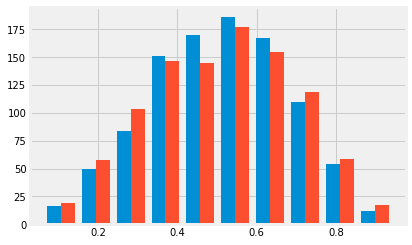

In [31]:
plt.hist(validation[:,[1,2]])

In [32]:
from sklearn.metrics import roc_curve, confusion_matrix, log_loss
def print_validation_results(validation):
    print('Log Loss U: %.5f' % log_loss(validation[:,0], validation[:,1]))
    print('Log Loss C: %.5f' % log_loss(validation[:,0], validation[:,2]))

    fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,1])
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve - U')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    fpr, tpr, tresh = roc_curve(validation[:,0], validation[:,2])
    ax.plot(fpr, tpr, color='orangered', lw=2, label='ROC curve - C')
    ax.legend(loc="lower right")

    validation_binary = validation.copy()
    validation_binary[:,1] = (validation_binary[:,1] > 0.5).astype(int)
    validation_binary[:,2] = (validation_binary[:,2] > 0.5).astype(int)

    cm = confusion_matrix(validation_binary[:,0], validation_binary[:,1] > 0.5)
    print("CM Unconditional")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    cm = confusion_matrix(validation_binary[:,0], validation_binary[:,2] > 0.5)
    print("CM Conditional")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])

    bins = np.vstack([np.arange(0,1,0.1), np.arange(0.1,1.1,0.1)]).T
    binned = {'U': [], 'C': []}
    for r in bins:
        binned['U'].append(validation[(validation[:,1] >= r[0])&(validation[:,1] < r[1]),0].mean())
        binned['C'].append(validation[(validation[:,2] >= r[0])&(validation[:,2] < r[1]),0].mean())

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(bins.sum(axis=1)/2,binned['U'], lw=2, label='U')
    ax.plot(bins.sum(axis=1)/2,binned['C'], lw=2, label='C')
    ax.plot(bins.sum(axis=1)/2,bins.sum(axis=1)/2, lw=2, linestyle='--')
    ax.legend(loc="lower right")

Log Loss U: 0.61640
Log Loss C: 0.58625
CM Unconditional
[[ 0.63747454  0.36252546]
 [ 0.29862475  0.70137525]]
CM Conditional
[[ 0.65580448  0.34419552]
 [ 0.27897839  0.72102161]]


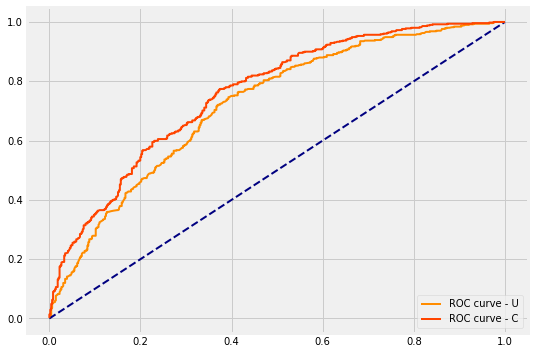

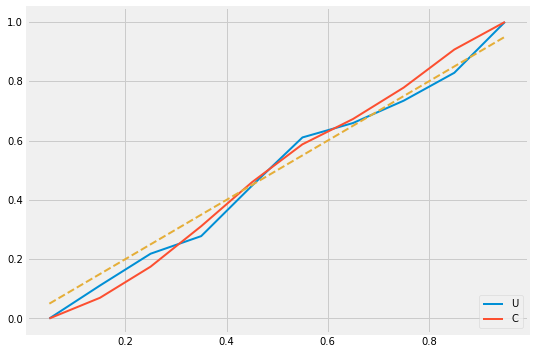

In [33]:
print_validation_results(validation) # normal score diff

Log Loss U: 0.61221
Log Loss C: 0.57277
CM Unconditional
[[ 0.6191446   0.3808554 ]
 [ 0.28094303  0.71905697]]
CM Conditional
[[ 0.66395112  0.33604888]
 [ 0.27111984  0.72888016]]


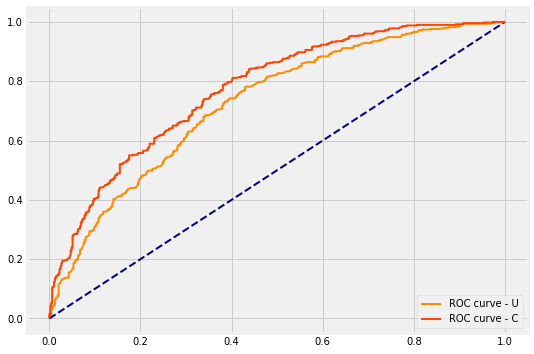

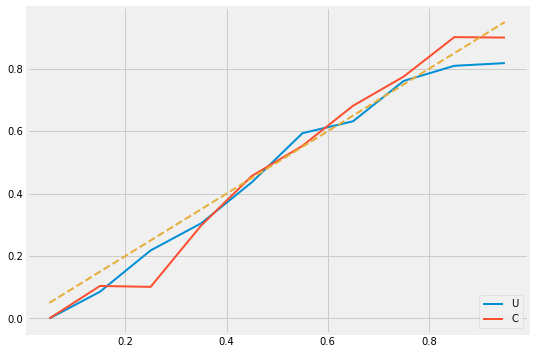

In [15]:
print_validation_results(validation) # sigmoid binary

rand guessing
Log Loss U: 0.72027
Log Loss C: 0.72354
CM Unconditional
[[ 0.49694501  0.50305499]
 [ 0.52062868  0.47937132]]
CM Conditional
[[ 0.48879837  0.51120163]
 [ 0.50491159  0.49508841]]


C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
C:\Users\kevin.pei\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.


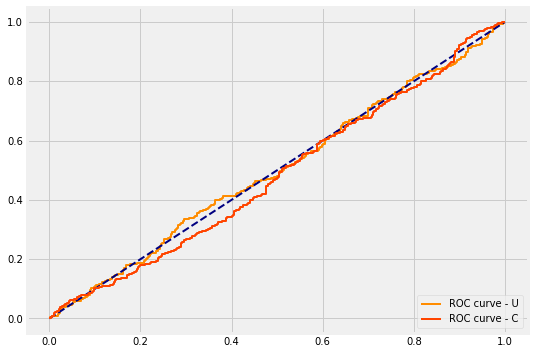

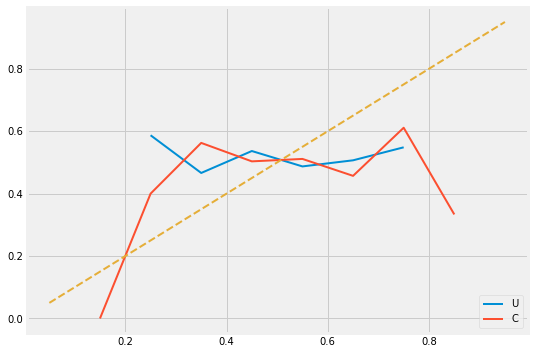

In [28]:
from scipy.stats import beta
print("rand guessing")
rand_guess = beta.rvs(a=10, b=10, size=(validation.shape[0],2))
validation[:,[1,2]] = rand_guess
print_validation_results(validation)

In [ ]:
sample_valid_set.reset_index(drop=True).to_csv('sample_valid_set.csv',index=False)